Исламова Сания Маратовна
НПИмд-01-24
(студ. билет 1132249576)

Задачи: 

Установить tensorflow 2. 

Создать трансформерную сеть для определения местоположения объектов относительно друг друга.
Сделать возможность сравнения (как в VQA) местоположения объектов друг с другом.
Relational reasoning – датасет CLEVR.

Зарегистрировать GitHub аккаунт.



Установка и проверка версии Tensorflow

In [8]:
#Установка Tensorflow 2
# pip install tensorflow / conda install tensorflow

#Проверка установки и версии tensorflow
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.17.0


Импорт и загрузка данных 

In [10]:
#Импорт необходимых библиотек
import tensorflow as tf
from tensorflow.keras import layers
import json
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Указываем путь к датасету CLEVR, который скачан на ноутбук (датасет без изображений)
path_to_dataset = "C:\\Users\\4eka0\\Downloads\\CLEVR\\questions\\CLEVR_train_questions.json"

# Загрузка JSON-файла
with open(path_to_dataset, 'r') as f:
    clevr_data = json.load(f)

questions = clevr_data['questions']
print(f"Всего вопросов в датасете: {len(questions)}")

Всего вопросов в датасете: 699989


Подготовка данных

In [12]:
# Подготовка всех вопросов и ответов
all_questions = [q['question'] for q in questions]
all_answers = [q['answer'] for q in questions]

# Преобразование ответов в числовой формат
unique_answers = list(set(all_answers))
answer_to_index = {ans: i for i, ans in enumerate(unique_answers)}
indexed_answers = [answer_to_index[ans] for ans in all_answers]

# Токенизация текстов
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_questions)
sequences = tokenizer.texts_to_sequences(all_questions)
word_index = tokenizer.word_index

# Паддинг последовательностей
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Преобразование ответов в numpy массив
y_train = np.array(indexed_answers)

Создание трансформерной модели

In [14]:
# Строим модель трансформера
def build_transformer_model(vocab_size, max_len, num_classes):
    inputs = layers.Input(shape=(max_len,))
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=128)(inputs)

    # Трансформерная часть
    x = layers.MultiHeadAttention(num_heads=4, key_dim=128)(embedding, embedding)
    x = layers.LayerNormalization()(x + embedding)
    x = layers.GlobalAveragePooling1D()(x)

    # Классификация
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Создание модели
model = build_transformer_model(vocab_size=len(word_index) + 1, max_len=max_len, num_classes=len(unique_answers))

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Функция для визуализации потерь и точности
history = model.fit(padded_sequences, y_train, epochs=5, batch_size=1000, validation_split=0.2)

Epoch 1/5
560/560 ━━━━━━━━━━━━━━━━━━━━ 2079s 4s/step - accuracy: 0.3430 - loss: 1.6345 - val_accuracy: 0.4174 - val_loss: 1.0844
Epoch 2/5
560/560 ━━━━━━━━━━━━━━━━━━━━ 887s 2s/step - accuracy: 0.4260 - loss: 1.0715 - val_accuracy: 0.4288 - val_loss: 1.0466
Epoch 3/5
560/560 ━━━━━━━━━━━━━━━━━━━━ 809s 1s/step - accuracy: 0.4296 - loss: 1.0499 - val_accuracy: 0.4300 - val_loss: 1.0446
Epoch 4/5
560/560 ━━━━━━━━━━━━━━━━━━━━ 851s 2s/step - accuracy: 0.4303 - loss: 1.0454 - val_accuracy: 0.4292 - val_loss: 1.0389
Epoch 5/5
560/560 ━━━━━━━━━━━━━━━━━━━━ 838s 1s/step - accuracy: 0.4321 - loss: 1.0396 - val_accuracy: 0.4355 - val_loss: 1.0353


Визуализация параметров точности и потерь

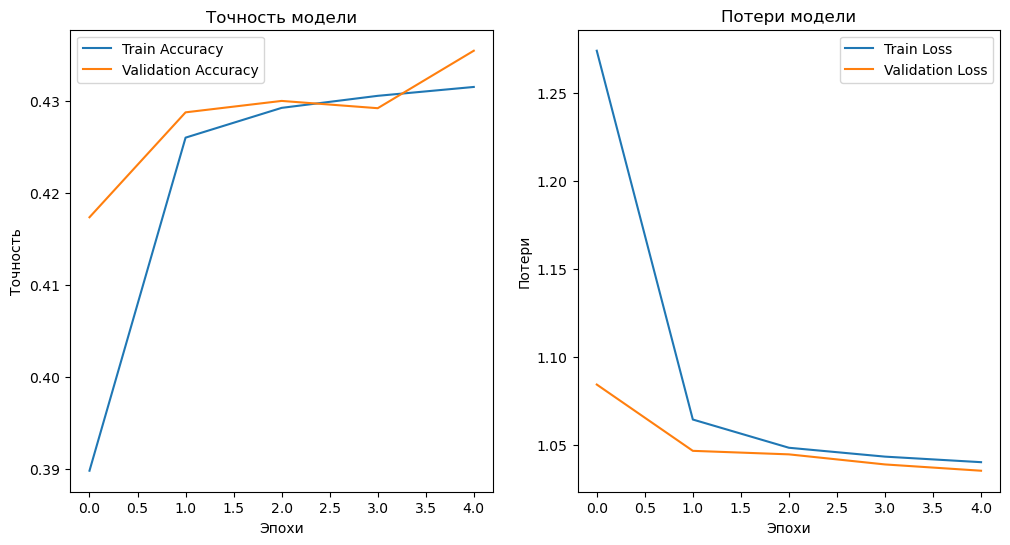

In [16]:
# Построение графиков точности и потерь
plt.figure(figsize=(12, 6))

# Точность
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Точность модели')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

# Потери
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Потери модели')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.show()

Тестирование модели на 10 случайных вопросах

In [18]:
# Функция для тестирования модели 
def test_model(model, tokenizer, questions, answers, num_samples=10):
    random_questions = random.sample(list(zip(questions, answers)), num_samples)
    
    for i, (question, answer) in enumerate(random_questions):
        sequence = tokenizer.texts_to_sequences([question])
        padded = pad_sequences(sequence, maxlen=max_len)
        prediction = model.predict(padded)
        predicted_answer = unique_answers[np.argmax(prediction)]
        
        print(f"Вопрос {i + 1}: {question}")
        print(f"Реальный ответ: {answer}")
        print(f"Предсказанный ответ: {predicted_answer}")
        print("-" * 50)

# Тестирование модели на случайных вопросах
test_model(model, tokenizer, all_questions, all_answers)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Вопрос 1: Is there a big matte object that has the same shape as the cyan metal object?
Реальный ответ: yes
Предсказанный ответ: yes
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Вопрос 2: Are there any spheres of the same color as the big metallic object?
Реальный ответ: no
Предсказанный ответ: yes
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Вопрос 3: There is a matte cylinder that is the same size as the cyan thing; what is its color?
Реальный ответ: blue
Предсказанный ответ: gray
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Вопрос 4: There is a object that is on the left side of the big cyan object and behind the small blue cylinder; what size is it?
Реальный ответ: large
Предсказанный ответ: small
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Вопрос 5: Is the number of re

Визуализация внимания

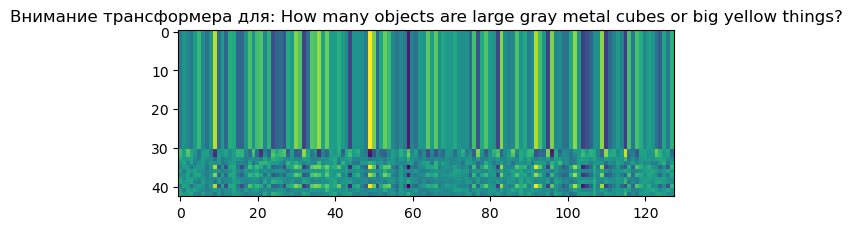

In [20]:
# Функция для визуализации внимания
def visualize_attention(model, sentence, tokenizer):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(sequence, maxlen=max_len)
# Получение внимания
    attention_layer = model.layers[2]  # MultiHeadAttention слой
    attention_output = tf.keras.Model(inputs=model.input, outputs=attention_layer.output)
    attention_weights = attention_output(padded)

    # Визуализация внимания
    plt.imshow(attention_weights[0].numpy(), cmap='viridis')
    plt.title(f"Внимание трансформера для: {sentence}")
    plt.show()

# Пример визуализации внимания для случайного вопроса
def visualize_random_attention(model, tokenizer, questions):
    random_question = random.choice(questions)  # Выбор случайного вопроса
    visualize_attention(model, random_question, tokenizer)

# Визуализация внимания для случайного вопроса
visualize_random_attention(model, tokenizer, all_questions)

Регистрация аккаунта на GitHub

Ссылка на акканут на GitHub:
https://github.com/SaniyaIslamova26/LPforAI/tree/main